In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
path_zomato = []
train_path_zomato = r"C:\Users\pkpra\OneDrive\Desktop\Vivek\Havells Assignment\Data\Delivery_Partner_Data\training_set\Zomato"
for path in os.listdir(train_path_zomato):
    if '.jpg' in path:
        path_zomato.append(os.path.join(train_path_zomato, path))
        
path_swiggy = []
train_path_swiggy = r"C:\Users\pkpra\OneDrive\Desktop\Vivek\Havells Assignment\Data\Delivery_Partner_Data\training_set\Swiggy"
for path in os.listdir(train_path_swiggy):
    if '.jpg' in path:
        path_swiggy.append(os.path.join(train_path_swiggy, path))
        
path_dunzo = []
train_path_dunzo = r"C:\Users\pkpra\OneDrive\Desktop\Vivek\Havells Assignment\Data\Delivery_Partner_Data\training_set\Dunzo"
for path in os.listdir(train_path_dunzo):
    if '.jpg' in path:
        path_dunzo.append(os.path.join(train_path_dunzo, path))
        
path_other = []
train_path_other = r"C:\Users\pkpra\OneDrive\Desktop\Vivek\Havells Assignment\Data\Delivery_Partner_Data\training_set\Other"
for path in os.listdir(train_path_other):
    if '.jpg' in path:
        path_other.append(os.path.join(train_path_other, path))
        
len(path_swiggy), len(path_zomato), len(path_dunzo), len(path_other)

(15, 15, 15, 15)

In [3]:
train_dataset_path = r'C:\Users\pkpra\OneDrive\Desktop\Vivek\Havells Assignment\Data\Delivery_Partner_Data\training_set'
validation_dataset_path = r'C:\Users\pkpra\OneDrive\Desktop\Vivek\Havells Assignment\Data\Delivery_Partner_Data\test_set'

In [4]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 60 images belonging to 4 classes.


In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 20 images belonging to 4 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Dunzo
1 : Other
2 : Swiggy
3 : Zomato


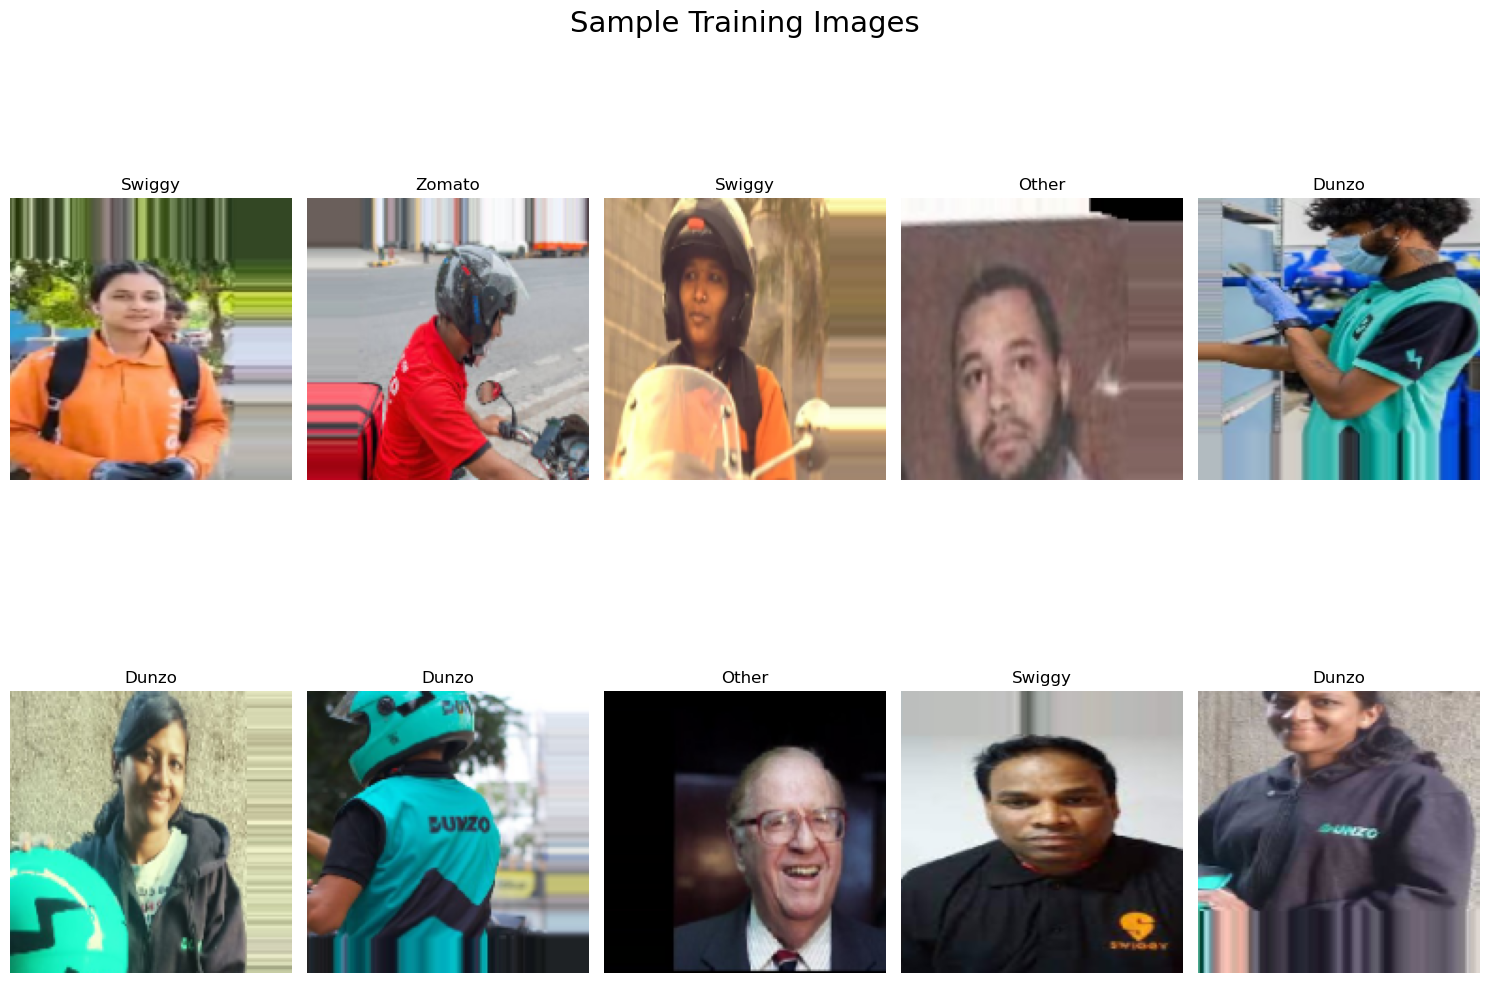

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [9]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(3, 3), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=4, activation='softmax')
    ])
    
    return model

In [10]:
cnn_model = create_model()

In [11]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 activation (Activation)     (None, 148, 148, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 64)        0

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [13]:
optimizer = Adam(learning_rate=0.001)

In [14]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [15]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
2/2 - 7s - loss: 1.5633 - accuracy: 0.5167 - val_loss: 1.3324 - val_accuracy: 0.2500 - lr: 0.0010 - 7s/epoch - 3s/step
Epoch 2/50
2/2 - 4s - loss: 1.2601 - accuracy: 0.6833 - val_loss: 1.2840 - val_accuracy: 0.3500 - lr: 0.0010 - 4s/epoch - 2s/step
Epoch 3/50
2/2 - 4s - loss: 0.5151 - accuracy: 0.8500 - val_loss: 1.2403 - val_accuracy: 0.5000 - lr: 0.0010 - 4s/epoch - 2s/step
Epoch 4/50
2/2 - 5s - loss: 0.9199 - accuracy: 0.7833 - val_loss: 1.2391 - val_accuracy: 0.4500 - lr: 0.0010 - 5s/epoch - 2s/step
Epoch 5/50
2/2 - 5s - loss: 0.7784 - accuracy: 0.8167 - val_loss: 1.3312 - val_accuracy: 0.4500 - lr: 0.0010 - 5s/epoch - 2s/step
Epoch 6/50
2/2 - 5s - loss: 0.6076 - accuracy: 0.8667 - val_loss: 1.3001 - val_accuracy: 0.3000 - lr: 0.0010 - 5s/epoch - 2s/step
Epoch 7/50
2/2 - 5s - loss: 0.7792 - accuracy: 0.8833 - val_loss: 1.2273 - val_accuracy: 0.4500 - lr: 0.0010 - 5s/epoch - 2s/step
Epoch 8/50
2/2 - 5s - loss: 0.3506 - accuracy: 0.9333 - val_loss: 1.2162 - val_accuracy: 0

In [30]:
cnn_model.save('delivery_guy_classification.h5')

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

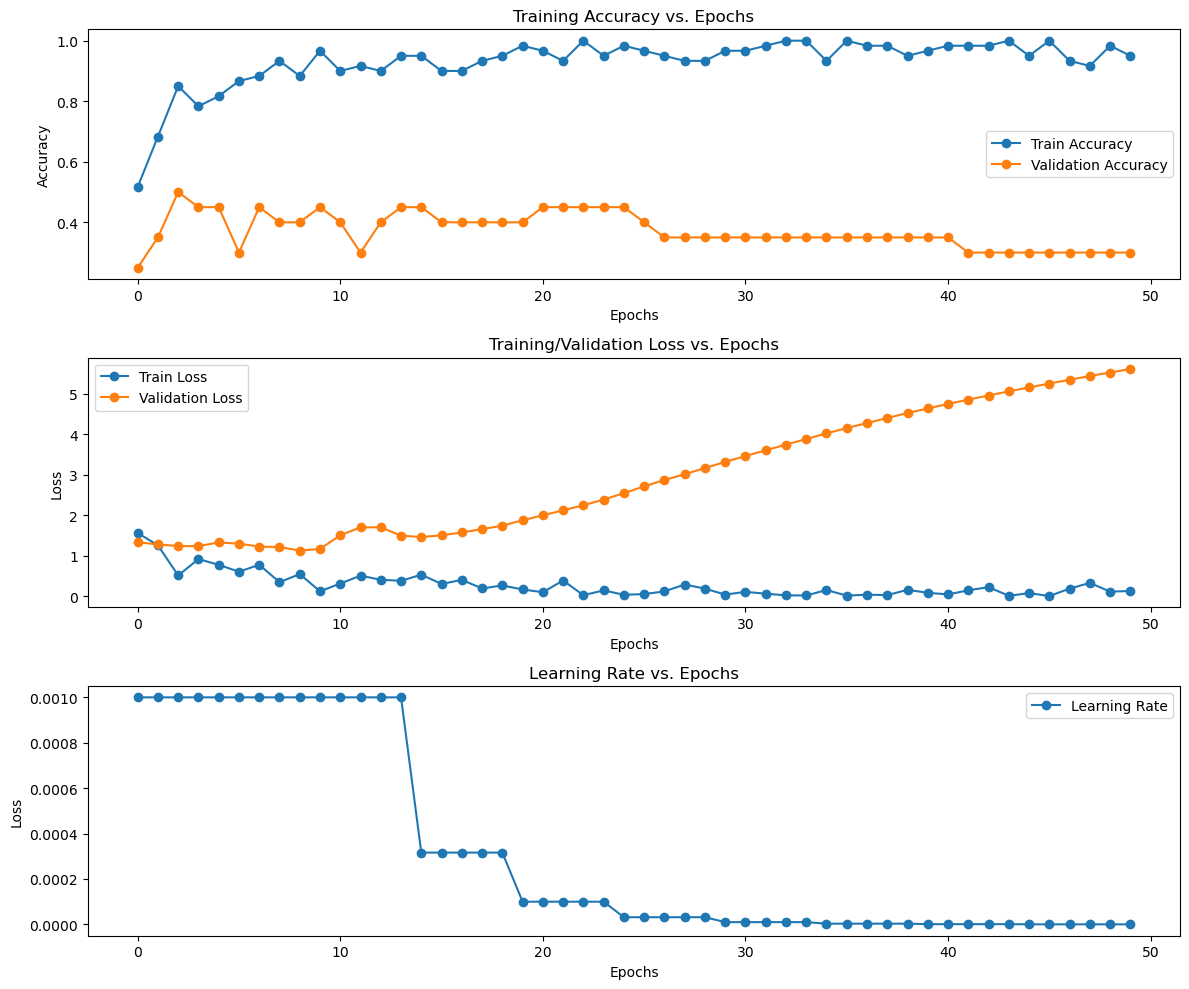

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [18]:
test_dataset = r'C:\Users\pkpra\OneDrive\Desktop\Vivek\Havells Assignment\Data\Delivery_Partner_Data\test_set'

In [19]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 20 images belonging to 4 classes.


In [20]:
predictions = cnn_model.predict(test_generator)

1/1 [==============================] - 1s 511ms/step


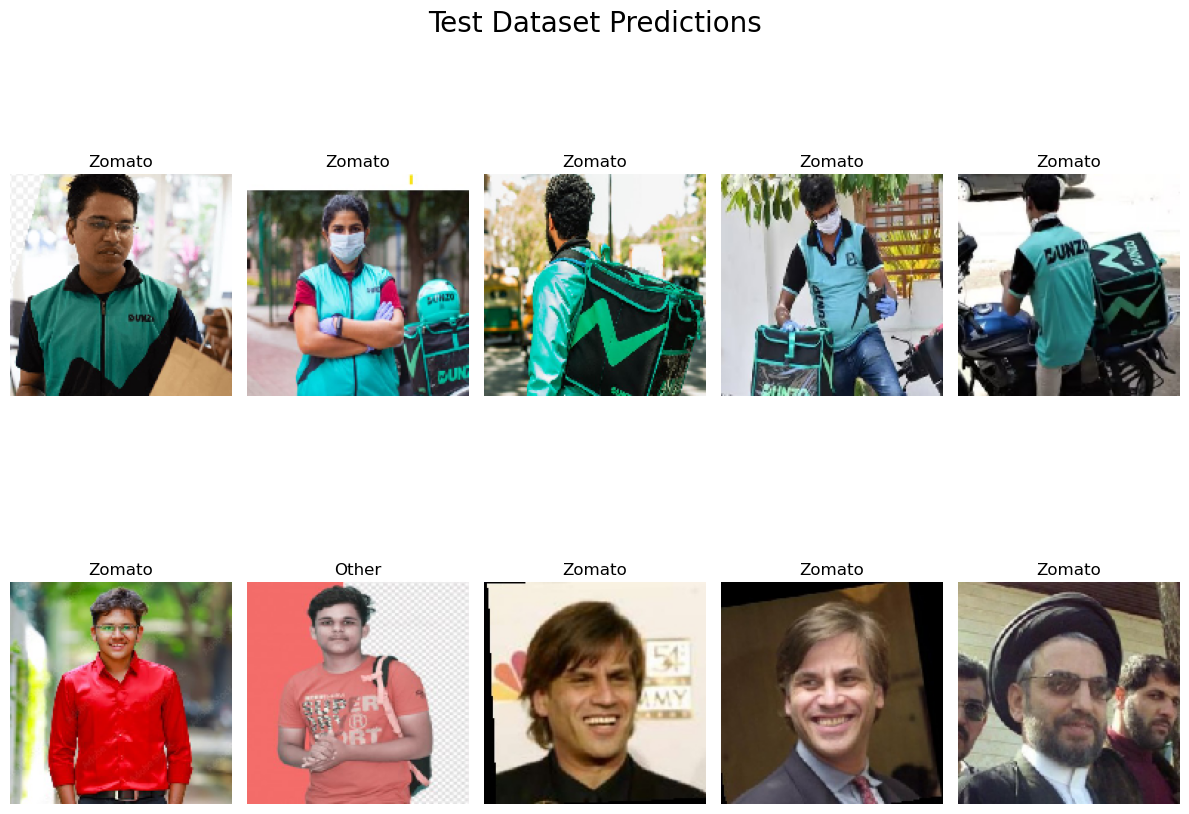

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [22]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 354ms/step - loss: 5.6085 - accuracy: 0.3000


In [23]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     5.608457088470459
Test Accuracy: 0.30000001192092896


In [24]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

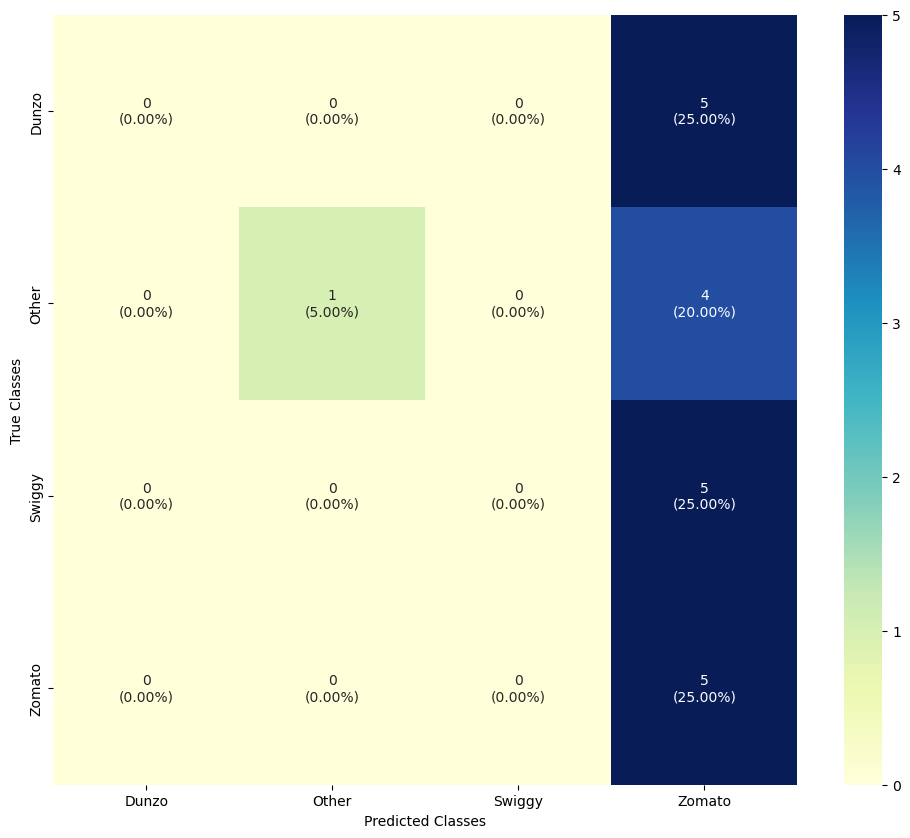

In [25]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [26]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

       Dunzo       0.00      0.00      0.00         5
       Other       1.00      0.20      0.33         5
      Swiggy       0.00      0.00      0.00         5
      Zomato       0.26      1.00      0.42         5

    accuracy                           0.30        20
   macro avg       0.32      0.30      0.19        20
weighted avg       0.32      0.30      0.19        20



In [27]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [28]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

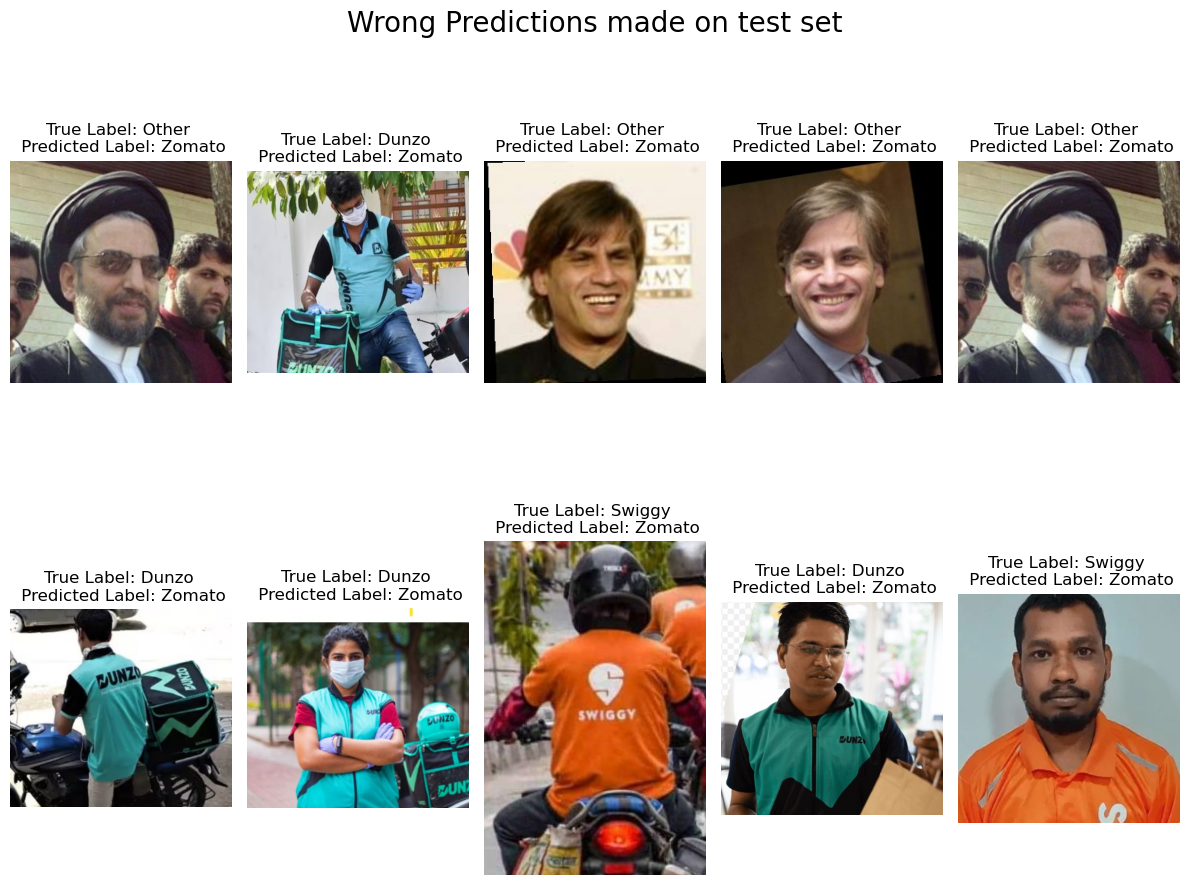

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()